# Описание задачи

Есть таблица с данными о займах выданных малому бизнесу в америке за часть 20 и 21 века.
В таблице есть данные о том был ли займ выплачен или нет.
Ставиться задача классификации: по данным займа определить будет ли он полностью выплачен или нет 

# Предобработка данных

In [1]:
import numpy as np              # Одномерные и многомерные массивы (array)
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import matplotlib.pyplot as plt # Научная графика
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

In [2]:
data_raw = pd.read_csv('SBAnational.csv', low_memory=False)

In [3]:
data_raw.shape

(899164, 27)

In [4]:
data_raw.head(5)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [5]:
data_raw = data_raw.drop(columns=['Name', 'City', 'Zip', 'Bank','LowDoc', 'DisbursementGross', 'ChgOffPrinGr', 'BalanceGross'])

В признаке RevLineCr были найдены значению смысл которых нигде не описан, так как их количество крайне мало, следует оставить в датасете только "понятные" значения

In [6]:
bool_mask = data_raw['RevLineCr'] == 'N'
bool_mask |= data_raw['RevLineCr'] == '0' 
bool_mask |= data_raw['RevLineCr'] == 'Y' 
bool_mask |= data_raw['RevLineCr'] == 'T'

data_raw = data_raw[bool_mask]

Конвертация категориальных признаков для дальнейшей работы

In [7]:
def convert_from_str_to_float(column):
    column = column.str.removeprefix("$")
    column = column.str.removesuffix(" ")
    column = column.str.replace(',', '')
    column = column.astype('float64')

    return column

In [8]:
data_raw['State'] = data_raw['State'].astype('category')
data_raw['BankState'] = data_raw['BankState'].astype('category')
data_raw['MIS_Status'] = data_raw['MIS_Status'].astype('category')
data_raw['RevLineCr'] = data_raw['RevLineCr'].astype('category')

data_raw['GrAppv'] = convert_from_str_to_float(data_raw['GrAppv'])
data_raw['SBA_Appv'] = convert_from_str_to_float(data_raw['SBA_Appv'])

В столбце NAICS в первых двух цифрах закодировано значение индустрии, остальные цифры задают лишь уникальный номер предприятия

In [9]:
data_raw['NAICS'] = data_raw['NAICS'] // 10000
data_raw['NAICS'].astype('category')

data_raw = data_raw[data_raw['MIS_Status'].notna()]

С учётом специфики данной задачи можно все даты конвертировать в года и интерпретировать их как целое число, с которым сможет работать модель

In [10]:
data_raw['ApprovalDate'] = pd.to_datetime(data_raw['ApprovalDate'])
data_raw['ChgOffDate'] = pd.to_datetime(data_raw['ChgOffDate'])
data_raw['DisbursementDate'] = pd.to_datetime(data_raw['DisbursementDate'])

data_raw = data_raw[data_raw['ApprovalDate'] < pd.to_datetime('01.01.2020')]

def truncate_date_to_year(elem):
    if pd.isnull(elem):
        return 0
    return int(elem.year)

data_raw['ApprovalDate'] = data_raw['ApprovalDate'].apply(truncate_date_to_year)
data_raw['ChgOffDate'] = data_raw['ChgOffDate'].apply(truncate_date_to_year)
data_raw['DisbursementDate'] = data_raw['DisbursementDate'].apply(truncate_date_to_year)
data_raw['ApprovalDate'] = data_raw['ApprovalDate'].astype('int64')
data_raw['ChgOffDate'] = data_raw['ChgOffDate'].astype('int64')
data_raw['DisbursementDate'] = data_raw['DisbursementDate'].astype('int64')

def remove_strange_years(elem):
    if(elem == '1976A'):
        return '1976'
    return elem

data_raw['ApprovalFY'] = data_raw['ApprovalFY'].apply(remove_strange_years)
data_raw['ApprovalFY'].value_counts()
data_raw['ApprovalFY'] =  data_raw['ApprovalFY'].astype('int64')

/tmp/ipykernel_9691/2006507995.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_raw['ApprovalDate'] = pd.to_datetime(data_raw['ApprovalDate'])
/tmp/ipykernel_9691/2006507995.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_raw['ChgOffDate'] = pd.to_datetime(data_raw['ChgOffDate'])
/tmp/ipykernel_9691/2006507995.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_raw['DisbursementDate'] = pd.to_datetime(data_raw['DisbursementDate'])


# Анализ данных

In [11]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 892500 entries, 0 to 899163
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   LoanNr_ChkDgt     892500 non-null  int64   
 1   State             892488 non-null  category
 2   BankState         890996 non-null  category
 3   NAICS             892500 non-null  int64   
 4   ApprovalDate      892500 non-null  int64   
 5   ApprovalFY        892500 non-null  int64   
 6   Term              892500 non-null  int64   
 7   NoEmp             892500 non-null  int64   
 8   NewExist          892366 non-null  float64 
 9   CreateJob         892500 non-null  int64   
 10  RetainedJob       892500 non-null  int64   
 11  FranchiseCode     892500 non-null  int64   
 12  UrbanRural        892500 non-null  int64   
 13  RevLineCr         892500 non-null  category
 14  ChgOffDate        892500 non-null  int64   
 15  DisbursementDate  892500 non-null  int64   
 16  MIS_Sta

In [12]:
data_raw.describe()

,LoanNr_ChkDgt,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,ChgOffDate,DisbursementDate,GrAppv,SBA_Appv
count,8.925000e+05,892500.000000,892500.000000,892500.000000,892500.000000,892500.000000,892366.000000,892500.000000,892500.000000,892500.000000,892500.000000,892500.000000,892500.000000,8.925000e+05,8.925000e+05
mean,4.760178e+09,39.677844,2000.931888,2001.164375,110.740617,11.403408,1.280387,8.478839,10.857871,2756.506253,0.760371,365.009914,1996.344142,1.929508e+05,1.495664e+05
std,2.533737e+09,26.260497,5.898733,5.902185,78.879008,73.943503,0.451726,237.567853,238.000472,12764.290811,0.645955,774.422126,98.797043,2.830657e+05,2.278304e+05
min,1.000014e+09,0.000000,1973.000000,1973.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+03,5.000000e+02
25%,2.585617e+09,23.000000,1996.000000,1997.000000,60.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1997.000000,3.500000e+04,2.125000e+04
50%,4.344224e+09,44.000000,2002.000000,2003.000000,84.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2002.000000,9.000000e+04,6.160000e+04
75%,6.854669e+09,56.000000,2006.000000,2006.000000,120.000000,10.000000,2.000000,1.000000,4.000000,1.000000,1.000000,0.000000,2006.000000,2.250000e+05,1.750000e+05
max,9.996003e+09,92.000000,2014.000000,2014.000000,569.000000,9999.000000,2.000000,8800.000000,9500.000000,99999.000000,2.000000,2026.000000,2048.000000,5.000000e+06,4.500000e+06


In [13]:
data_raw.describe(include='category')

,State,BankState,RevLineCr,MIS_Status
count,892488,890996,892500,892500
unique,51,56,4,2
top,CA,CA,N,P I F
freq,129963,117603,419170,735128


По данным метрикам можно заметить, что во многих показателях присутствуют выбросы, их необходимо удалить

In [14]:
data_raw.head()

,LoanNr_ChkDgt,State,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,ChgOffDate,DisbursementDate,MIS_Status,GrAppv,SBA_Appv
0,1000014003,IN,OH,45,1997,1997,84,4,2.0,0,0,1,0,N,0,1999,P I F,60000.0,48000.0
1,1000024006,IN,IN,72,1997,1997,60,2,2.0,0,0,1,0,N,0,1997,P I F,40000.0,32000.0
2,1000034009,IN,IN,62,1997,1997,180,7,1.0,0,0,1,0,N,0,1997,P I F,287000.0,215250.0
3,1000044001,OK,OK,0,1997,1997,60,2,1.0,0,0,1,0,N,0,1997,P I F,35000.0,28000.0
4,1000054004,FL,FL,0,1997,1997,240,14,1.0,7,7,1,0,N,0,1997,P I F,229000.0,229000.0


Матрица корреляции

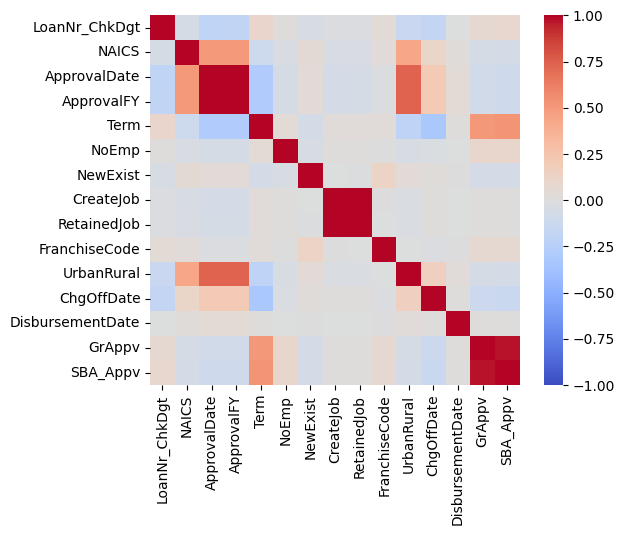

In [15]:
corr_mat = data_raw.corr(numeric_only=True)
sns.heatmap(corr_mat, square=True, vmin=-1, vmax=1, cmap='coolwarm')
pass

Как видно из корреляционной матрицы есть признаки которые сильное коррелируют, следовательно их можно удалить практически не теряя при этом данных о займе  

In [16]:
data_raw = data_raw.drop(columns=['ApprovalDate', 'RetainedJob', 'SBA_Appv'])

Борьба с выбросами

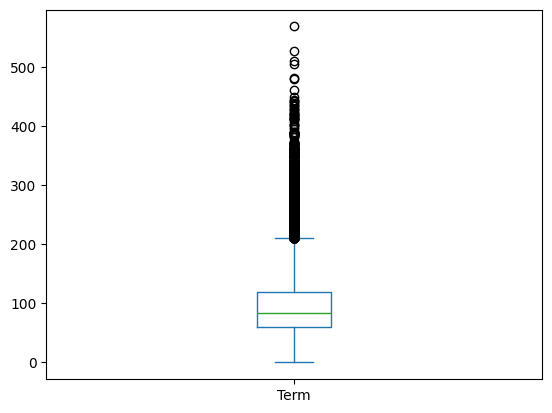

In [17]:
data_raw['Term'].plot(kind='box')
pass

In [18]:
data_raw = data_raw[data_raw['Term'].quantile(0.999) > data_raw["Term"]]

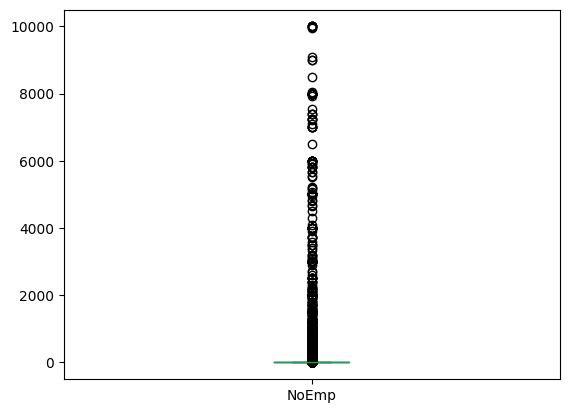

In [19]:
data_raw['NoEmp'].plot(kind='box')
pass

In [20]:
data_raw = data_raw[data_raw['NoEmp'].quantile(0.999) > data_raw['NoEmp']]

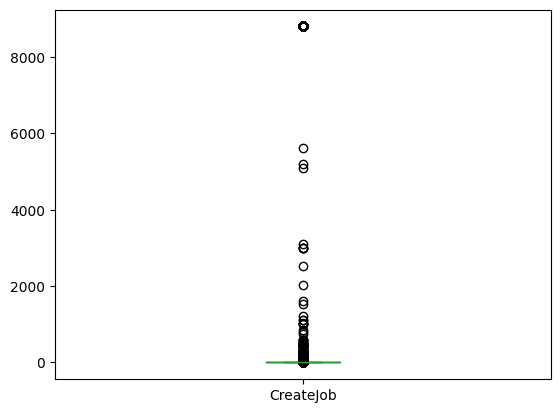

In [21]:
data_raw['CreateJob'].plot(kind='box')
pass

In [22]:
data_raw = data_raw[data_raw['CreateJob'].quantile(0.999) > data_raw['CreateJob']]

<Axes: >

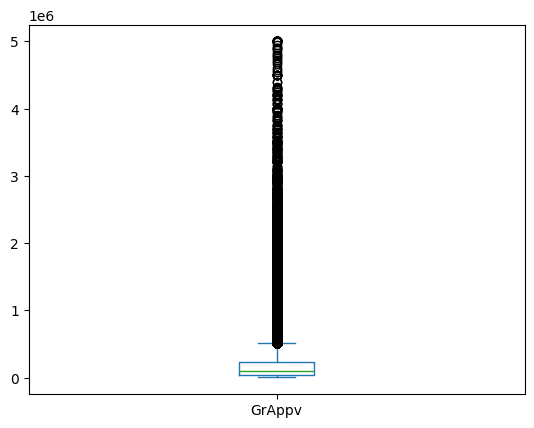

In [23]:
data_raw['GrAppv'].plot(kind='box')

In [24]:
data_raw = data_raw[data_raw['GrAppv'].quantile(0.99) > data_raw['GrAppv']]


Матрица рассеяния

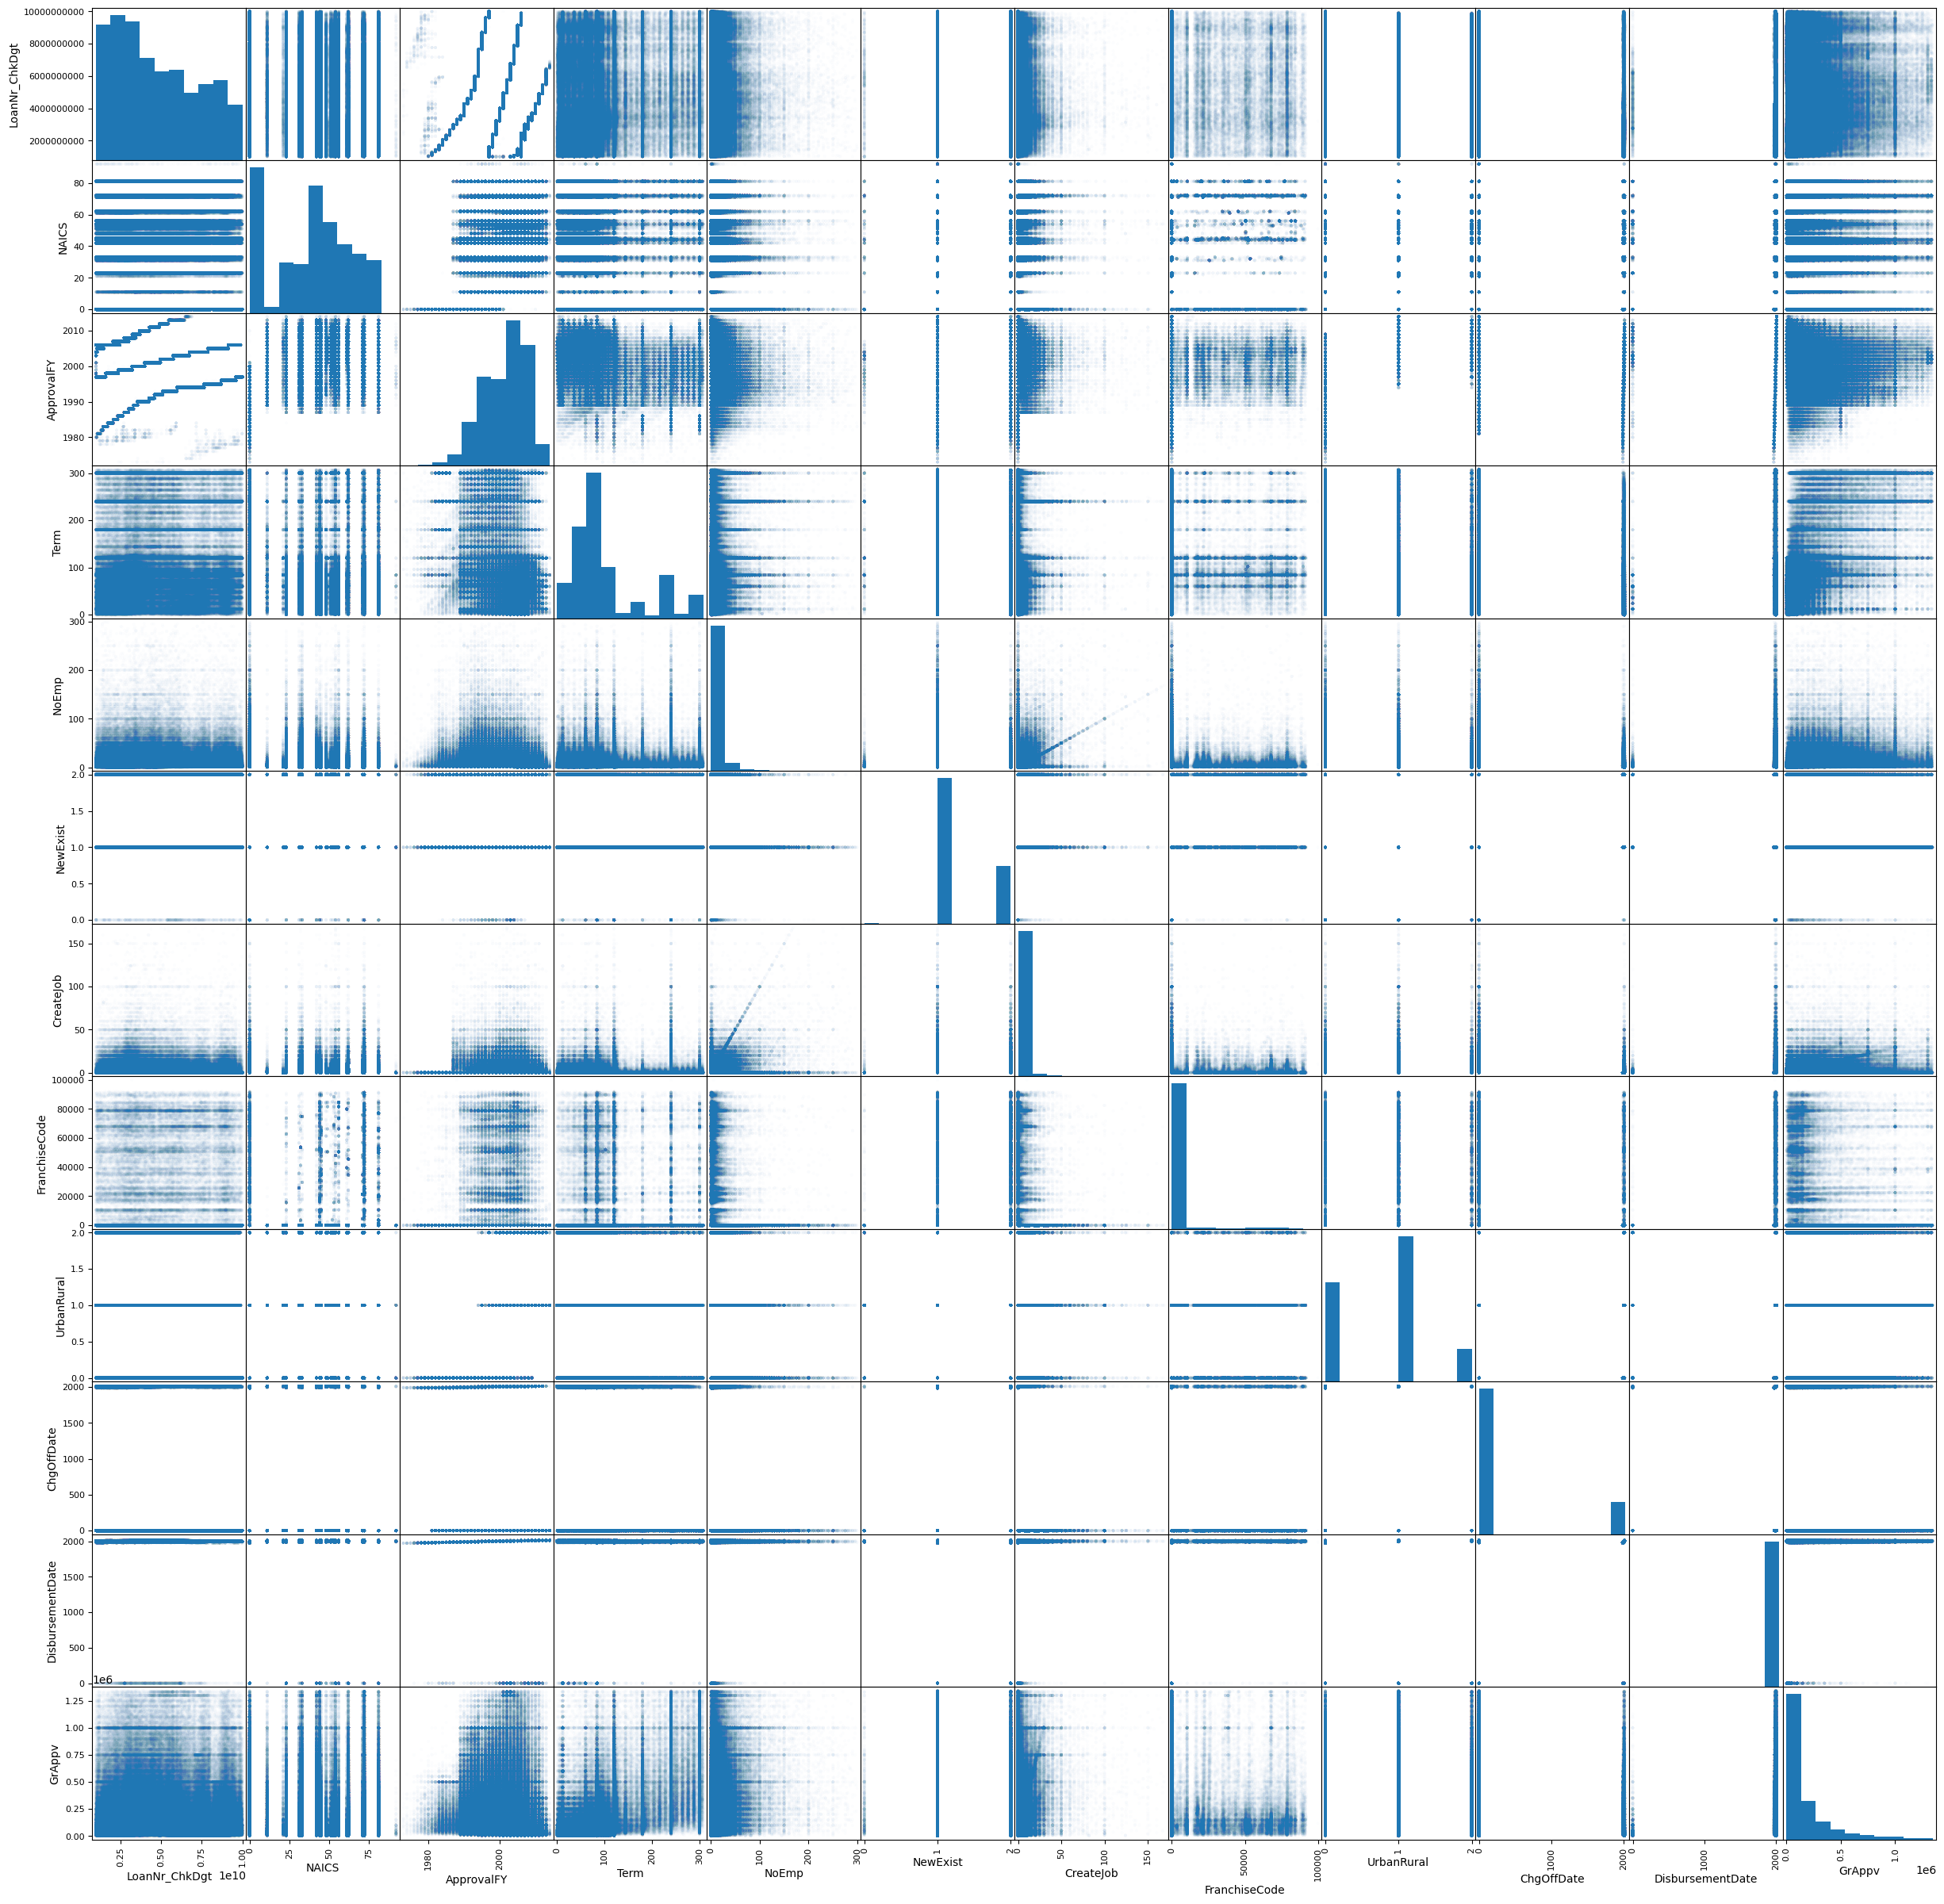

In [25]:
from pandas.plotting import scatter_matrix
scatter_matrix(data_raw, alpha = .01, figsize = (30, 30))
pass

In [26]:
X = data_raw.drop(columns='MIS_Status')
y = data_raw['MIS_Status']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test

(748672, 132119)

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 748672 entries, 29392 to 123556
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   LoanNr_ChkDgt     748672 non-null  int64   
 1   State             748661 non-null  category
 2   BankState         747402 non-null  category
 3   NAICS             748672 non-null  int64   
 4   ApprovalFY        748672 non-null  int64   
 5   Term              748672 non-null  int64   
 6   NoEmp             748672 non-null  int64   
 7   NewExist          748570 non-null  float64 
 8   CreateJob         748672 non-null  int64   
 9   FranchiseCode     748672 non-null  int64   
 10  UrbanRural        748672 non-null  int64   
 11  RevLineCr         748672 non-null  category
 12  ChgOffDate        748672 non-null  int64   
 13  DisbursementDate  748672 non-null  int64   
 14  GrAppv            748672 non-null  float64 
dtypes: category(3), float64(2), int64(10)
memory usage: 

Заполнение пустых значений

In [28]:
X_train.isnull().sum()

LoanNr_ChkDgt          0
State                 11
BankState           1270
NAICS                  0
ApprovalFY             0
Term                   0
NoEmp                  0
NewExist             102
CreateJob              0
FranchiseCode          0
UrbanRural             0
RevLineCr              0
ChgOffDate             0
DisbursementDate       0
GrAppv                 0
dtype: int64

In [29]:
from sklearn.impute import SimpleImputer
columns_to_fill = ['State', 'BankState', 'NewExist']
most_freg_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
most_freg_imputer.fit(X_train[columns_to_fill])

X_train[columns_to_fill] = most_freg_imputer.transform(X_train[columns_to_fill])

Кодирование категориальных признаков с помощью OneHotEncoder

In [30]:
from sklearn.preprocessing import OneHotEncoder
columns_to_encode = ['State', 'BankState', 'NewExist', 'RevLineCr']
one_hot_encode = OneHotEncoder(drop='first', sparse_output=False)
one_hot_encode.fit(X_train[columns_to_encode])

dummies = pd.DataFrame(one_hot_encode.transform(X_train[columns_to_encode]),
                       columns=one_hot_encode.get_feature_names_out(), index=X_train.index)

X_train = pd.concat((X_train, dummies), axis=1).drop(columns_to_encode, axis=1)

Нормализация числовых признаков

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)

# Тренировка моделей и оценка результатов

In [32]:
X_test[columns_to_fill] = most_freg_imputer.transform(X_test[columns_to_fill])

dummies = pd.DataFrame(one_hot_encode.transform(X_test[columns_to_encode]),
                       columns=one_hot_encode.get_feature_names_out(), index=X_test.index)

X_test = pd.concat((X_test, dummies), axis=1).drop(columns_to_encode, axis=1)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)
pass

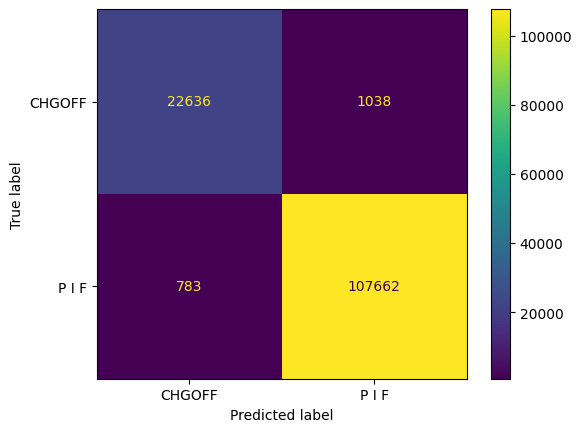

In [34]:
def plot_conf_matrix(y_test, y_pred):
    conf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
    disp = sklearn.metrics.ConfusionMatrixDisplay(conf_matrix, display_labels=knn.classes_)

    disp.plot()

y_pred = knn.predict(X_test)
plot_conf_matrix(y_test, y_pred)

По данным приведенным в таблице можно сделать вывод, что даже самая простая модель работает достаточно хорошо.
Скорее всего в данной задачи более "болезненными" являются ошибки 1 рода, а значит при дальнейшем подборе моделей и параметров можно поработать над уменьшением данных ошибок.

In [35]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(20,10))
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(20, 10))

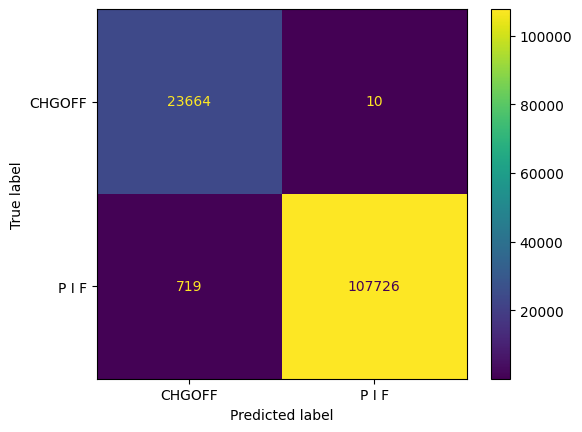

In [36]:
y_pred = model.predict(X_test)
plot_conf_matrix(y_test, y_pred)